## Install Libraries

In [1]:
%pip install scikit-surprise

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [2]:
from collections import defaultdict
from surprise import Dataset, Reader, dump
from surprise import BaselineOnly
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise import SVD, SlopeOne, CoClustering
from surprise.model_selection import cross_validate, KFold
import matplotlib.pyplot as plt
import pandas as pd


## Load Datasets

In [3]:
reader = Reader(line_format="user item rating timestamp", sep=",", skip_lines=1)


In [4]:
data = Dataset.load_from_file("ml-latest-small/ratings.csv", reader=reader)


In [5]:
algos = [BaselineOnly(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), KNNBaseline(), SVD(), SlopeOne(), CoClustering()]

## Rating Prediction

In [6]:
results = []

for algo in algos:
    result = cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)
    mean_scores = pd.DataFrame.from_dict(result).mean()
    algo_name = type(algo).__name__
    mean_scores['Algorithm'] = algo_name
    results.append(mean_scores)

results_df = pd.DataFrame(results).set_index('Algorithm').sort_values('test_rmse')
results_df

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8601  0.8768  0.8703  0.8741  0.8797  0.8722  0.0068  
MAE (testset)     0.6635  0.6746  0.6721  0.6757  0.6759  0.6724  0.0046  
Fit time          0.16    0.21    0.21    0.19    0.21    0.20    0.02    
Test time         0.10    0.12    0.10    0.20    0.13    0.13    0.04    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
BaselineOnly,0.872201,0.672369,0.196272,0.129068
SVD,0.873066,0.670550,0.768930,0.232279
KNNBaseline,0.874612,0.668504,0.291329,1.907923
KNNWithZScore,0.894428,0.678830,0.204037,1.825212
KNNWithMeans,0.897073,0.685302,0.151334,1.567180
SlopeOne,0.899393,0.687146,5.434805,7.099137
CoClustering,0.944743,0.731583,1.896365,0.163027
KNNBasic,0.945871,0.724686,0.116927,1.412508


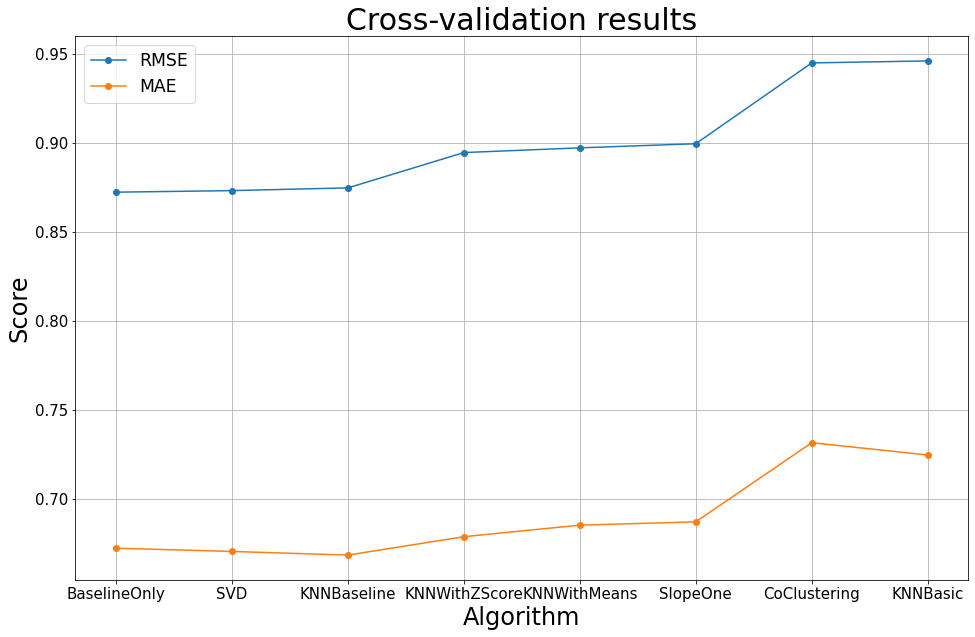

In [7]:
plt.figure(figsize=(16, 10))
plt.plot(results_df['test_rmse'], marker='o', label='RMSE')
plt.plot(results_df['test_mae'], marker='o', label='MAE')
plt.title('Cross-validation results', fontsize=30)
plt.xlabel('Algorithm', fontsize=24)
plt.ylabel('Score', fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='xx-large')
plt.grid(visible=True)
plt.show()

## Precision, Recall and F1 Score


In [8]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    precision = sum(prec for prec in precisions.values()) / len(precisions)
    recall = sum(rec for rec in recalls.values()) / len(recalls)

    return precision, recall


In [9]:
kf = KFold(n_splits=5)
results_df = pd.DataFrame(columns=['Algorithm', 'Precision@10', 'Recall@10', 'F1 Score'])

for algo in algos:
    precision_scores = []
    recall_scores = []
    f1_score_scores = []
    for trainset, testset in kf.split(data):
        predictions = algo.test(testset)
        precision, recall = precision_recall_at_k(predictions, k=10, threshold=4)
        f1_score = 2 * (precision * recall) / (precision + recall)
        
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_score_scores.append(f1_score)
        
    mean_precision = sum(precision_scores) / len(precision_scores)
    mean_recall = sum(recall_scores) / len(recall_scores)
    mean_f1_score = sum(f1_score_scores) / len(f1_score_scores)

    results_df = results_df.append({'Algorithm': type(algo).__name__,
                                    'Precision@10': mean_precision,
                                    'Recall@10': mean_recall,
                                    'F1 Score': mean_f1_score}, ignore_index=True)

results_df = results_df.set_index('Algorithm')
results_df

,Precision@10,Recall@10,F1 Score
Algorithm,,,
BaselineOnly,0.562327,0.256928,0.352679
KNNBasic,0.813299,0.414142,0.548792
KNNWithMeans,0.703773,0.397760,0.508226
KNNWithZScore,0.726752,0.409591,0.523872
KNNBaseline,0.759915,0.392979,0.518015
SVD,0.715530,0.350241,0.470264
SlopeOne,0.746035,0.386291,0.508984
CoClustering,0.618293,0.354801,0.450861


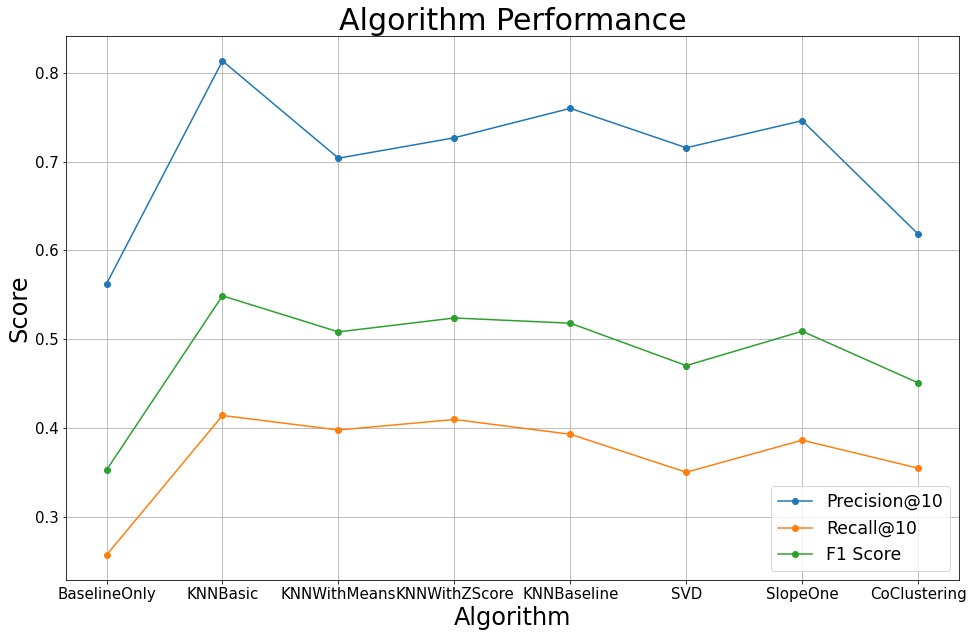

In [10]:
plt.figure(figsize=(16, 10))
plt.plot(results_df['Precision@10'], marker='o', label='Precision@10')
plt.plot(results_df['Recall@10'], marker='o', label='Recall@10')
plt.plot(results_df['F1 Score'], marker='o', label='F1 Score')
plt.title('Algorithm Performance', fontsize=30)
plt.xlabel('Algorithm', fontsize=24)
plt.ylabel('Score', fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='xx-large')
plt.grid(visible=True)
plt.show()

The KNNBaseline model is an optimal choice for the recommender system due to its low RMSE and MAE, as well as high precision, recall, and F1 score when compared to other models.